# Deliverable #3 : Patient loyalty & feature importance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from dmba import classificationSummary
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

no display found. Using non-interactive Agg backend


In [3]:
df_p = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Patient List.xlsx')

p_a = pd.read_csv('/Users/jialinshang/Desktop/field project/raw/Appointment List.csv', 
                           names=['Office ID', 'Appointment ID', 'Patient ID', 'Provider Short ID', 'Appointment Date', 
                                  'Appointment Length','Appointment Status','New Patient','Missed Appointment',
                                  'DateTime Marked As Missed','Marked As Missed By','Cancelled Appointment',
                                  'DateTime Marked As Cancelled','Marked As Cancelled By','Appointment Posted'],
                           parse_dates=['Appointment Date','DateTime Marked As Missed', 'DateTime Marked As Cancelled'])

df_provider = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Provider List.xlsx')

df_office = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Office List.xlsx')

df_recall = pd.read_csv('/Users/jialinshang/Desktop/field project/raw/Recall List.csv' , header=None)
df_recall.columns = ['Patient ID', 'Office ID', 'Procedure Code', 'Recall Date', 'Recall Reason']



# - Define loyalty

In [10]:
# choose the hygiene patient who sucessfully visit the dentist 
d = ['D1110', 'D1120', 'D4910', 'ZD0901', 'ZD0903', 'ZD0318', 'ZS0320']
hygiene = df_recall[df_recall["Procedure Code"].str.contains('|'.join(d))]
hygiene.groupby(['Procedure Code']).size()

hygiene = hygiene.drop_duplicates(subset=['Patient ID'])
hygienepatient = pd.merge(df_p,hygiene,on='Patient ID',how = 'inner')

patientapp = pd.merge(p_a,hygienepatient,on='Patient ID',how = 'inner')
normal_appointments = patientapp[(patientapp['Cancelled Appointment'] == 'N') & (patientapp['Missed Appointment'] == 'N')]

patient_count = normal_appointments.groupby(['Patient ID']).size().to_frame('size').reset_index()
patient_count = patient_count.sort_values(by=['size'],ascending=False)
patient_count = patient_count.iloc[1: , :]


In [11]:
# Define loyalty by calculating the freqeuncy
# Loyalty: hygiene patient come to the dentist every 9 months
p_normal = pd.merge(patient_count,hygienepatient,on='Patient ID',how = 'inner')
p_normal['Duration'] = df_p['Patient Last Visit Date'] - df_p['Patient First Visit Date']
p_normal['Frequency'] = p_normal['size']/p_normal['Duration'].dt.days
p_normal.replace([np.inf, -np.inf], 0, inplace=True)
freq = 1/270
loyalty = p_normal[(p_normal['Frequency'] >= freq)]
loyalty = loyalty.sort_values(by=['Frequency'],ascending=False)
loyalty['loyalty'] = 'Y'
loyalty = loyalty.drop(columns=['size', 'Responsible Party ID', 'Patient Zip',
       'Active/Inactive', 'Birth Year', 'Patient Gender',
       'Patient Home Office ID', 'Patient Home Office Name',
       'Patient First Visit Date', 'Patient Last Visit Date', 'Patient Type',
       'Responsible Party Type', 'Duration', 'Frequency','Office ID', 'Procedure Code', 'Recall Date',
              'Recall Reason'])

df_loyalty = pd.merge(hygienepatient,loyalty,on='Patient ID',how = 'left')
df_loyalty['loyalty'].fillna('N', inplace=True)

d = {'N': 0, 'Y': 1}
df_loyalty['loyalty'] = df_loyalty['loyalty'].astype(str).map(d)


In [15]:
# merge appointment and provider tables
# calculate patient age
df_loyalty1 = df_loyalty.copy()
df_loyalty1 = df_loyalty1.drop(columns=['Office ID'])
df_loyalty1 = pd.merge(df_loyalty1,p_a,on='Patient ID',how = 'left')
df_loyalty1 = df_loyalty1.drop_duplicates('Patient ID')
df_loyalty1 = pd.merge(df_loyalty1,df_provider,on='Provider Short ID',how = 'left')

mapping = {'Active': 1, 'Inactive': 0}
mapping2 = {'Y': 1, 'N': 0}
df_loyalty1 = df_loyalty1.replace({'Active/Inactive': mapping})
df_loyalty1 = df_loyalty1.replace({'New Patient': mapping2})

df_loyalty1['Age'] = 2022 - df_loyalty1['Birth Year']

df_loyalty1 = pd.merge(df_loyalty1,df_office,on='Office ID',how = 'left')


In [58]:
# choose the columns we want to use in our model
# deal with missing data
df_loyalty2 = df_loyalty1.copy()
df_loyalty2 = df_loyalty2[df_loyalty2["Office Name"].str.contains("Gentle Dental",na=False)]
#df_loyalty2['Provider Specialty'].value_counts() (No Hygienist)
df_loyalty2 = df_loyalty2.drop(['Patient ID', 'Responsible Party ID', 'Patient Zip', 'Birth Year',
                                'Patient Home Office ID','Patient Home Office Name', 'Patient First Visit Date',
                                'Patient Last Visit Date','Recall Date', 'Recall Reason', 'Office ID', 'Appointment ID', 'Provider Short ID',
                                'Appointment Date', 'New Patient','Missed Appointment', 'DateTime Marked As Missed',
                                'Marked As Missed By', 'Cancelled Appointment','DateTime Marked As Cancelled', 
                                'Marked As Cancelled By', 'Provider First Name', 'Provider Last Name',
                                'Internal Office Name','Zip Code'], axis=1)

df_loyalty2.isnull().sum()

df_loyalty2["Patient Gender"] = df_loyalty2["Patient Gender"].replace(' ', np.nan)
df_loyalty2["Patient Gender"] = df_loyalty2["Patient Gender"].fillna("Unknown")
df_loyalty2["Patient Type"] = df_loyalty2["Patient Type"].fillna("Unknown")
df_loyalty2["Responsible Party Type"] = df_loyalty2["Responsible Party Type"].fillna("Unknown")
df_loyalty2["Appointment Posted"] = df_loyalty2["Appointment Posted"].replace(' ', np.nan)
df_loyalty2["Appointment Posted"] = df_loyalty2["Appointment Posted"].fillna("Unknown")
df_loyalty2["Provider Specialty"] = df_loyalty2["Provider Specialty"].fillna("Unknown")

df_loyalty2.isnull().sum()


Active/Inactive           0
Patient Gender            0
Patient Type              0
Responsible Party Type    0
Procedure Code            0
loyalty                   0
Appointment Length        0
Appointment Status        0
Appointment Posted        0
Provider Specialty        0
Age                       0
Office Name               0
dtype: int64

In [17]:
df_loyalty2.describe()

,Active/Inactive,loyalty,Appointment Length,Appointment Status,Age
count,153148.000000,153148.000000,153148.000000,153148.000000,153148.000000
mean,0.951994,0.381931,52.785280,13.375258,43.385111
std,0.213779,0.485861,14.560522,4.201743,18.756222
min,0.000000,0.000000,10.000000,1.000000,0.000000
25%,1.000000,0.000000,40.000000,15.000000,29.000000
50%,1.000000,0.000000,60.000000,15.000000,40.000000
75%,1.000000,1.000000,60.000000,15.000000,58.000000
max,1.000000,1.000000,240.000000,15.000000,122.000000


# - Data exploration
## - loyalty vs disloyalty

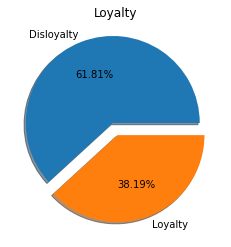

In [19]:
# data exploration -- loyalty vs disyalty
df_loyalty2['loyalty'].value_counts()

label=['Disloyalty','Loyalty']
value_label=df_loyalty2['loyalty'].value_counts()
explode=[0.1,0.05]
fig,ax=plt.subplots()
ax.pie(value_label,explode=explode,labels=label,autopct='%1.2f%%',shadow=True)
ax.set(title='Loyalty');

## 1. Loyalty differences based on Genders
### Formular 1 (bar plot):  for each gender, loyalty / (loyalty + disloyalty)
Compare to themselves in each category

Eg, total loyalty female patients / total number of female patients

In [20]:
# gender size distribution
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['loyalty'].groupby(df_loyalty2['Patient Gender']).count()
print(y)

Patient Gender
F          31158
M          27215
U             86
Unknown       33
Name: loyalty, dtype: int64


Patient Gender
F          0.382823
M          0.381227
U          0.313869
Unknown    0.343750
Name: loyalty, dtype: float64


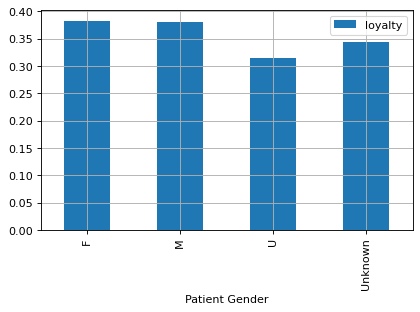

In [21]:
# based on gender
fig1 = plt.figure(figsize = (6,8),dpi=80)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty2['loyalty'].groupby(df_loyalty2['Patient Gender']).count()
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['loyalty'].groupby(df_loyalty2['Patient Gender']).count()/n
print(y)
y.plot(kind='bar')
plt.legend()
plt.grid()

### Formular 2 (pie chart): number of loyalty patients in each gender / total loyalty patients
Comparison among different groups

Eg, total female patients that are loyalty / total loyalty patients

Patient Gender
F          0.532688
M          0.465277
U          0.001470
Unknown    0.000564
Name: loyalty, dtype: float64


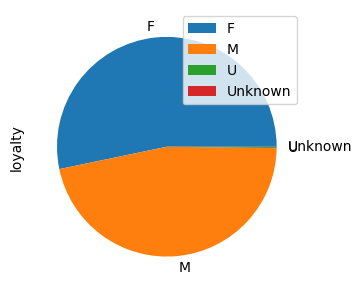

In [22]:
fig1 = plt.figure(figsize = (6,8),dpi=100)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].count()
y = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].groupby(df_loyalty2['Patient Gender']).count()/n
print(y)
y.plot(kind='pie')
plt.legend()
plt.grid()

## 2. Loyalty differences between age groups
### Formular 1 (bar plot):  for each group, loyalty / (loyalty + disloyalty)
Eg, total loyalty patients from age 0 - 10 / total number of patients from age 0 - 10

Age
(0, 10]       0.005400
(10, 20]      0.026269
(20, 30]      0.072374
(30, 40]      0.080249
(40, 50]      0.056638
(50, 60]      0.057702
(60, 70]      0.047092
(70, 80]      0.025152
(80, 90]      0.008867
(90, 100]     0.002050
(100, 110]    0.000104
(110, 120]    0.000007
Name: Age, dtype: float64


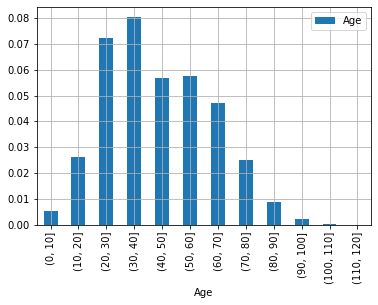

In [23]:
# based on age
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['Age']
n = df_loyalty2['Age'].count()
datanew = df_loyalty2.loc[df_loyalty2['loyalty']== 1]
bins = np.arange(0,122,10)
age_bins = pd.cut(y,bins)
y = datanew.groupby(age_bins)['Age'].count()/n
y.plot(kind='bar')
plt.legend()
plt.grid()
print(y)

### Formular 2 (pie chart): number of loyalty patients in each age group / total loyalty patients
Eg, total loyalty patients from age 0 - 10 / total loyalty patient among all age groups

Age
(0, 10]       0.014139
(10, 20]      0.068779
(20, 30]      0.189496
(30, 40]      0.210114
(40, 50]      0.148294
(50, 60]      0.151080
(60, 70]      0.123299
(70, 80]      0.065855
(80, 90]      0.023217
(90, 100]     0.005368
(100, 110]    0.000274
(110, 120]    0.000017
Name: Age, dtype: float64


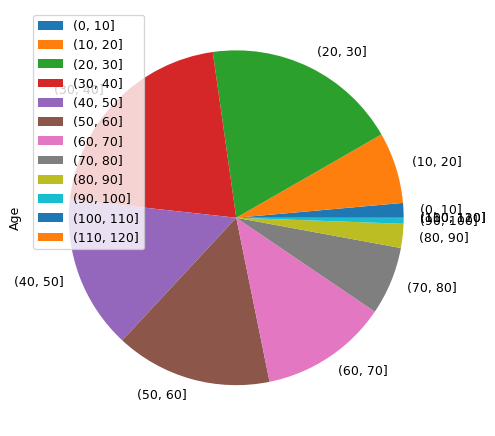

In [24]:
fig1 = plt.figure(figsize = (6,8),dpi=90)
n = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].count()
y = df_loyalty2.loc[df_loyalty2['loyalty']==1]['Age']
datanew = df_loyalty2.loc[df_loyalty2['loyalty']==1]
bins = np.arange(0,122,10)
age_bins = pd.cut(y,bins)
y = datanew.groupby(age_bins)['Age'].count()/n
y.plot(kind='pie')
plt.legend()
plt.grid()
print(y)

### Top 3 age groups based on formula two

In [25]:
y.sort_values(ascending = False).head(3)

Age
(30, 40]    0.210114
(20, 30]    0.189496
(50, 60]    0.151080
Name: Age, dtype: float64

## 3. Loyalty differences between office (gental dental only)
### Formular 1 (bar plot):  for each office, loyalty / (loyalty + disloyalty)
Eg, Loyalty patients at GD Arlington / total patients at GT Arlington;  Loyalty patients at GD Belmont / total patients at GT Belmont

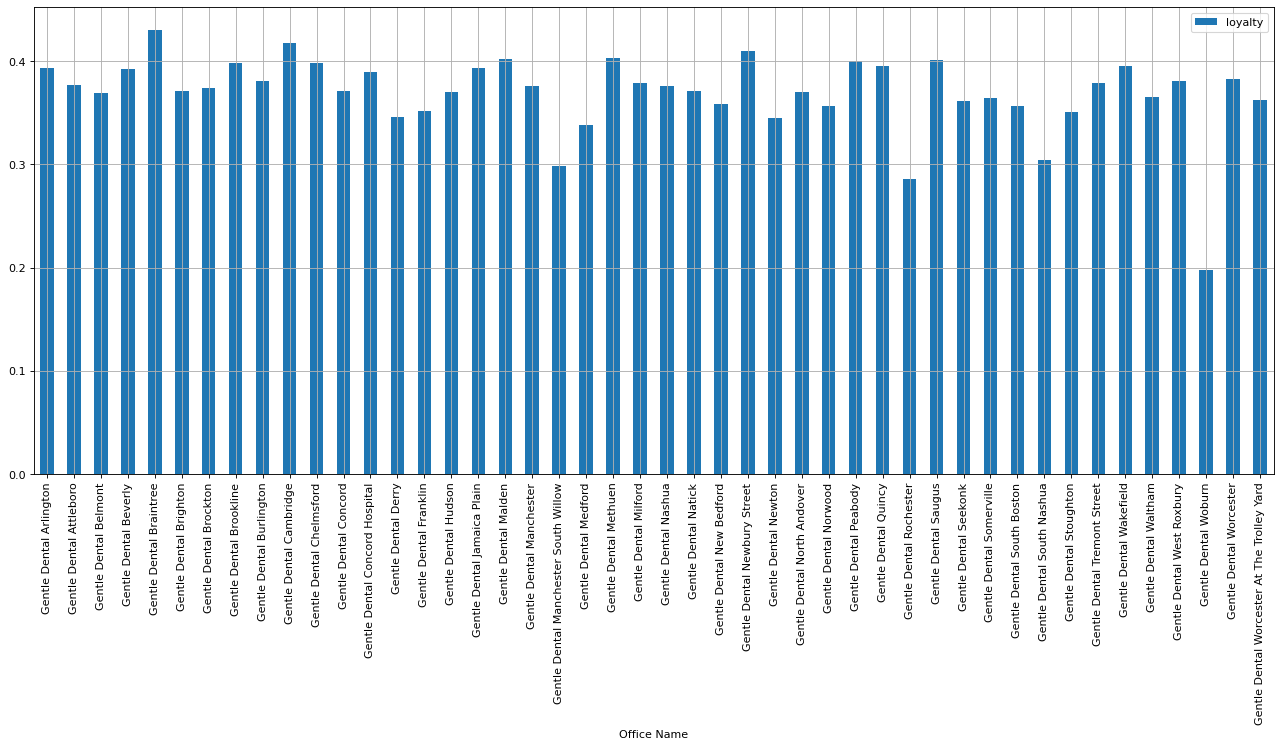

In [26]:
# based on office
fig1 = plt.figure(figsize = (20,17),dpi=80)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty2['loyalty'].groupby(df_loyalty2['Office Name']).count()
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['loyalty'].groupby(df_loyalty2['Office Name']).count()/n
y.plot(kind='bar')
plt.legend()
plt.grid()

### Top 5 Gental dental offices (based on formula 1: for each office, loyalty / (loyalty + disloyalty))
Eg, Loyalty patients at GD Arlington / total patients at GT Arlington;  Loyalty patients at GD Belmont / total patients at GT Belmont

In [27]:
# order by
y.sort_values(ascending = False).head()

Office Name
Gentle Dental Braintree         0.430465
Gentle Dental Cambridge         0.417259
Gentle Dental Newbury Street    0.409517
Gentle Dental Methuen           0.403292
Gentle Dental Malden            0.402321
Name: loyalty, dtype: float64

### Top 5 Gental dental offices (based on formula 2: number of loyalty patients in one office / number of loyalty patients in all offices))
Eg, Loyalty patients at GD Arlington / total loyalty patients across all offices

In [28]:
n = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].count()
y = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].groupby(df_loyalty2['Office Name']).count()/n
y.sort_values(ascending = False).head()

Office Name
Gentle Dental Chelmsford        0.048417
Gentle Dental Newbury Street    0.047819
Gentle Dental Cambridge         0.043151
Gentle Dental Malden            0.039715
Gentle Dental Quincy            0.037646
Name: loyalty, dtype: float64

## 4. Loyalty differences between responsiable party type
### Formular 1 (bar plot):  for each party type, loyalty / (loyalty + disloyalty)
Eg, Loyalty patients marked as BK / total patients markd as BK

their according percentage: Responsible Party Type
BK         0.410714
CA         0.338137
CO         0.339607
DI         0.433402
EM         0.360606
IA         0.391753
IN         0.405438
MC         0.417910
NU         0.351864
OR         0.409471
PC         0.372881
PI              NaN
PR         0.463547
PS         0.390335
SD         0.800000
UA         0.371571
Unknown    0.371341
VA         0.585366
Name: loyalty, dtype: float64


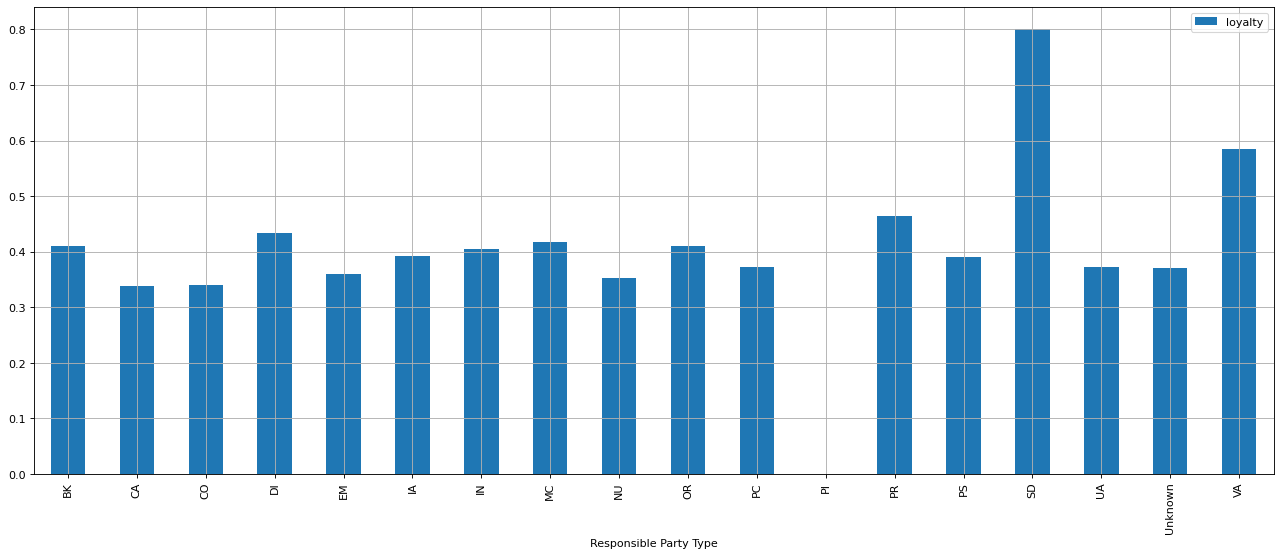

In [30]:
# based on responsiable party type
df_loyalty2 = df_loyalty2[df_loyalty2["Responsible Party Type"].str.contains("CAIN") == False]
fig1 = plt.figure(figsize = (20,17),dpi=80)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty2['loyalty'].groupby(df_loyalty2['Responsible Party Type']).count()
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['loyalty'].groupby(df_loyalty2['Responsible Party Type']).count()/n
y.plot(kind='bar')
plt.legend()
plt.grid()
print("their according percentage:", y)

### Top 5 responsiable party type (based on formula 1: for each party type, loyalty / (loyalty + disloyalty)
Eg, Loyalty patients marked as BK / total patients markd as BK

#### VA: veteran affairs, BK: bankruptcy, OR: ortho, UA: update address, EM: employee

In [31]:
y.sort_values(ascending = False).head()

Responsible Party Type
SD    0.800000
VA    0.585366
PR    0.463547
DI    0.433402
MC    0.417910
Name: loyalty, dtype: float64

### Top 5 Gental dental offices (based on formula 2: number of loyalty patients in each type / number of loyalty patients in all types))
Eg, number of Loyalty patients marked as IN/ total loyalty patients across all types

#### IN: insurance, CA: cash, OR: ortho, DI: discount, NU: needs updates

In [32]:
n = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].count()
y = df_loyalty2.loc[df_loyalty2['loyalty']==1]['loyalty'].groupby(df_loyalty2['Responsible Party Type']).count()/n
y.sort_values(ascending = False).head()

Responsible Party Type
IN    0.554452
CA    0.284791
OR    0.056914
DI    0.032432
NU    0.028243
Name: loyalty, dtype: float64

## 5. Loyalty differences between Provider Specialties
### Formular 1 (bar plot):  for each provider specialty, loyalty / (loyalty + disloyalty)
Eg, total Loyalty patients came for general dentist / total patients came for general dentist

Provider Specialty
Director           0.368242
Endodontist        0.413043
General Dentist    0.350927
Oral Surgeon       0.311765
Orthodontist       0.413153
Periodontist       0.422764
Unknown            0.382013
Name: loyalty, dtype: float64


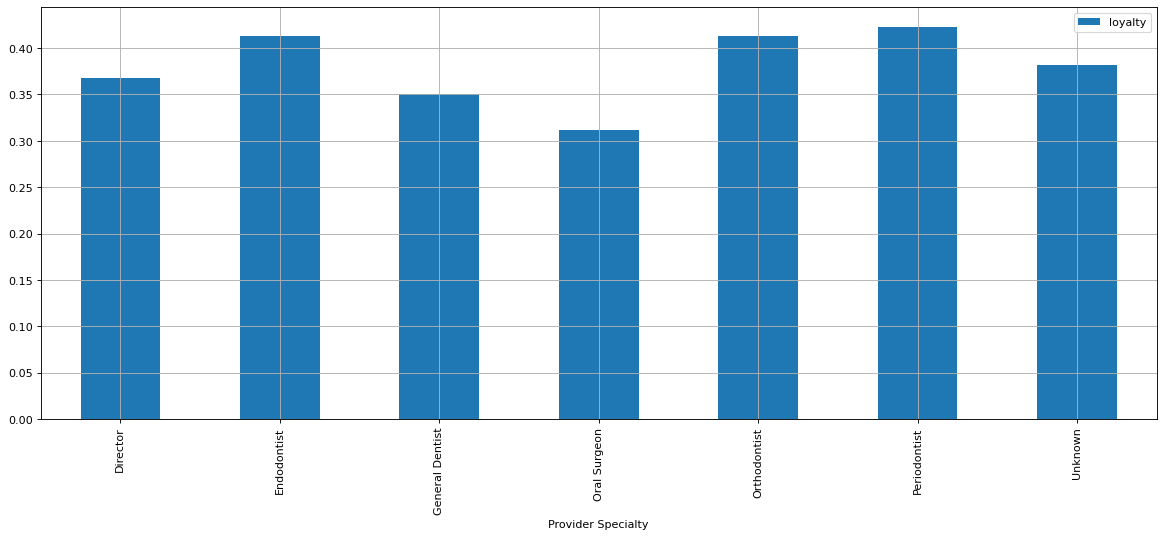

In [33]:
# based on provider specialty
fig1 = plt.figure(figsize = (18,15),dpi=80)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty2['loyalty'].groupby(df_loyalty2['Provider Specialty']).count()
y = df_loyalty2.loc[df_loyalty2['loyalty']== 1]['loyalty'].groupby(df_loyalty2['Provider Specialty']).count()/n
print(y)
y.plot(kind='bar')
plt.legend()
plt.grid()

### Top 5 responsiable provider specialties (based on formula 1:  for each provider specialty, loyalty / (loyalty + disloyalty)
Eg, total Loyalty patients came for general dentist / total patients came for general dentist

In [36]:
y.sort_values(ascending = False).head()

Provider Specialty
Periodontist    0.422764
Orthodontist    0.413153
Endodontist     0.413043
Unknown         0.382013
Director        0.368242
Name: loyalty, dtype: float64

### Formular 2 (pie chart): number of loyalty patients in one specialty / total loyalty patients among all specialties
Eg, total loyalty patients came for director / total loyalty patient among all provider specialties

Provider Specialty
Director           0.394984
Endodontist        0.009927
General Dentist    0.128527
Oral Surgeon       0.055381
Orthodontist       0.384013
Periodontist       0.027168
Name: loyalty, dtype: float64


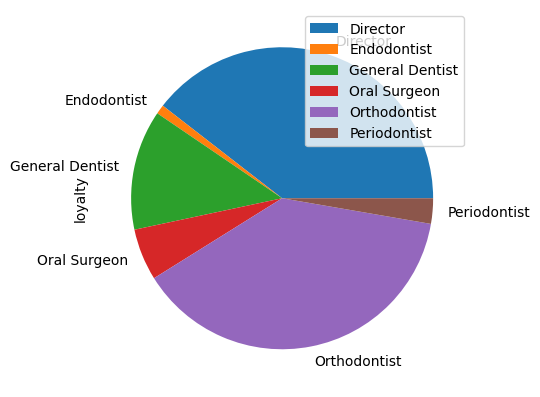

In [37]:
df_loyalty_u = df_loyalty2[df_loyalty2["Provider Specialty"].str.contains("Unknown") == False]
fig1 = plt.figure(figsize = (10,11),dpi= 100)
ax1 = fig1.add_subplot(2,1,1)
n = df_loyalty_u.loc[df_loyalty_u['loyalty']==1]['loyalty'].count()
y = df_loyalty_u.loc[df_loyalty_u['loyalty']==1]['loyalty'].groupby(df_loyalty_u['Provider Specialty']).count()/n
print(y)
y.plot(kind='pie')
plt.legend()
plt.grid()

### Top 5 provider specialties (based on formula 2: number of loyalty patients in one specialty / total loyalty patients among all specialties)
Eg, total loyalty patients came for director / total loyalty patient among all provider specialties

In [38]:
y.sort_values(ascending = False).head()

Provider Specialty
Director           0.394984
Orthodontist       0.384013
General Dentist    0.128527
Oral Surgeon       0.055381
Periodontist       0.027168
Name: loyalty, dtype: float64

## Machine learning

In [59]:
l = ['EF', 'CP', 'SS', 'OR', 'CH', 'PM', 'UP', 'CE', 'CT', 'CO', 'CN', 'HI', 
     'IA', 'PB', 'MA', 'CS', 'SD', 'PC', 'DC', 'DS', 'DB', 'DN', 'CL', 'IN', 'SC', 'VC', 'OS']
for i in l:
    if df_loyalty2['Patient Type'].str.contains(i) is True:
        df_loyalty2[i] = 1
    else:
        df_loyalty2[i] = 0

df_loyalty2 = df_loyalty2.drop(['Patient Type'], axis=1)

In [60]:
appointmenttype = [1,2,3,4,5,12,13,14,15]
typeapp = ['scheduled','comfirmed','left message','in operatory','in reception','missed','uncomfirmed','cancelled','checked out']
dfnew = pd.DataFrame({'Appointment Status':appointmenttype,'typeapp':typeapp})
df_loyalty2 = pd.merge(dfnew,df_loyalty2,on='Appointment Status',how = 'inner')


In [65]:
df_loyalty2 = df_loyalty2.drop(['Appointment Status'], axis=1)

In [67]:
df_loyalty2.columns

Index(['typeapp', 'Active/Inactive', 'Patient Gender',
       'Responsible Party Type', 'Procedure Code', 'loyalty',
       'Appointment Length', 'Appointment Posted', 'Provider Specialty', 'Age',
       'Office Name', 'EF', 'CP', 'SS', 'OR', 'CH', 'PM', 'UP', 'CE', 'CT',
       'CO', 'CN', 'HI', 'IA', 'PB', 'MA', 'CS', 'SD', 'PC', 'DC', 'DS', 'DB',
       'DN', 'CL', 'IN', 'SC', 'VC', 'OS'],
      dtype='object')

In [68]:
numerical=['Active/Inactive','Age','Appointment Length','New Patient','EF', 'CP', 'SS', 'OR',
'CH', 'PM', 'UP', 'CE', 'CT', 'CO', 'CN', 'HI', 'IA', 'PB', 'MA', 'CS',
'SD', 'PC', 'DC', 'DS', 'DB', 'DN', 'CL', 'IN', 'SC', 'VC', 'OS']
categorical=['Patient Gender','Responsible Party Type','Appointment Posted','Provider Specialty','Office Name',
            'Procedure Code','typeapp']

df = pd.get_dummies(df_loyalty2,columns=categorical)

In [69]:
df

,Active/Inactive,loyalty,Appointment Length,Age,EF,CP,SS,OR,CH,PM,...,Office Name_Gentle Dental Worcester At The Trolley Yard,Procedure Code_D1110,Procedure Code_ZD0901,typeapp_checked out,typeapp_comfirmed,typeapp_in operatory,typeapp_in reception,typeapp_left message,typeapp_scheduled,typeapp_uncomfirmed
0,1,1,60.0,74,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1,0,50.0,76,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1,1,50.0,58,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,0,50.0,60,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1,1,60.0,70,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153143,1,0,60.0,58,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
153144,1,0,20.0,33,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
153145,0,0,60.0,33,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
153146,1,0,60.0,37,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [77]:
sample = df.sample(frac = 0.01)

In [79]:
X = sample.drop(['loyalty'], axis=1)
y = sample['loyalty']

In [80]:
nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(x_nm, y_nm, test_size=0.25)

In [81]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [10,15,20],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)   
print(gs.best_params_) 

0.6491108188717843
{'criterion': 'entropy', 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 1000}


In [82]:
rf = RandomForestClassifier(criterion='entropy', 
                            n_estimators=1000,
                            min_samples_split=2,
                            min_samples_leaf=15,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

shuffle = ShuffleSplit(n_splits=10, test_size=.4)
CVInfo = cross_validate(rf, X_train, y_train, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

0.6572854291417165
0.6565868263473055


In [89]:
feature_names = X.columns.tolist()

In [90]:
rf.fit(X_train,y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

In [96]:
forest_importances = pd.DataFrame(forest_importances).sort_values(by=0, ascending=False)
forest_importances

,0
Appointment Length,0.187352
Age,0.131613
Appointment Posted_N,0.119348
Procedure Code_D1110,0.101572
Procedure Code_ZD0901,0.096804
...,...
Responsible Party Type_CAIN,0.000000
Responsible Party Type_BK,0.000000
Patient Gender_Unknown,0.000000
Patient Gender_U,0.000000


In [70]:
df1 = df.sample(frac = 0.3)

In [71]:
df1

,Active/Inactive,loyalty,Appointment Length,Age,EF,CP,SS,OR,CH,PM,...,Office Name_Gentle Dental Worcester At The Trolley Yard,Procedure Code_D1110,Procedure Code_ZD0901,typeapp_checked out,typeapp_comfirmed,typeapp_in operatory,typeapp_in reception,typeapp_left message,typeapp_scheduled,typeapp_uncomfirmed
133280,1,1,60.0,49,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
115482,1,1,60.0,58,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
84430,1,0,60.0,37,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
81571,1,0,60.0,39,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
128705,1,0,60.0,44,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147282,1,0,30.0,36,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
40812,1,0,60.0,59,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
21569,1,0,50.0,55,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
94316,1,0,60.0,29,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [72]:
X = df1.drop(['loyalty'], axis=1)
y = df1['loyalty']

In [73]:
nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(x_nm, y_nm, test_size=0.25)

In [74]:
x_nm

,Active/Inactive,Appointment Length,Age,EF,CP,SS,OR,CH,PM,UP,...,Office Name_Gentle Dental Worcester At The Trolley Yard,Procedure Code_D1110,Procedure Code_ZD0901,typeapp_checked out,typeapp_comfirmed,typeapp_in operatory,typeapp_in reception,typeapp_left message,typeapp_scheduled,typeapp_uncomfirmed
0,1,60.0,26,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,1,60.0,24,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,1,60.0,31,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,1,60.0,35,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,1,60.0,25,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35225,1,60.0,55,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
35226,1,60.0,57,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
35227,1,60.0,59,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
35228,1,60.0,24,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [10,15,20],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)   
print(gs.best_params_)  

In [ ]:
rf = RandomForestClassifier(criterion='gini', 
                            n_estimators=400,
                            min_samples_split=2,
                            min_samples_leaf=10,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

shuffle = ShuffleSplit(n_splits=10, test_size=.4)
CVInfo = cross_validate(rf, X_train, y_train, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

In [ ]:
feature_names = X.columns.tolist()

In [ ]:
rf.fit(X_train,y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

In [ ]:
forest_importances = pd.DataFrame(forest_importances).sort_values(by=0, ascending=False)
forest_importances